In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from collections import Counter
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.ticker import (PercentFormatter,MultipleLocator, AutoMinorLocator)
import seaborn as sns
import random

In [78]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
conn = psycopg2.connect(database="postgres",
                        host="pklmart.ckkvdwandqoa.us-east-1.rds.amazonaws.com",
                        user="cmcnicholas",
                        password="momentum101",
                        port="5432")
conn.autocommit = True

In [4]:
def pullawsdata(tablename):
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT column_name FROM information_schema.columns where table_name=\'{tablename}\';")
            cols=cursor.fetchall()
            cols = [cols[x][0] for x in range(len(cols))]
            cursor.execute(f"SELECT * FROM pklm_prd.{tablename}")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=cols))
        except Exception as inst:
            print(type(inst))
            print(inst.args)
            print(inst)

In [5]:
rally=pullawsdata('rally')
rally = rally[['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']]
rally['game_id'] = [int(x[1:]) for x in rally.game_id]
rally['rally_id'] = [int(x[1:]) for x in rally.rally_id]
rally = rally.sort_values(['game_id', 'rally_id', 'rally_nbr']).reset_index(drop=True)

In [6]:
game=pullawsdata('game')[['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']]
game['game_id'] = [int(x[1:]) for x in game.game_id]
game['match_id'] = [int(x[1:]) for x in game.match_id]
game.skill_lvl.iloc[game.skill_lvl == '5'] = '5.0'
game = game.sort_values(['match_id','game_id']).reset_index(drop=True)

In [7]:
#create column 'srv_win' capturing the rally winner if serving
sloc = rally.index[rally.srv_team_id == rally.w_team_id]
rally['srv_win'] = rally.srv_team_id.iloc[sloc]

In [9]:
to_games=[]
for i in game.game_id:
    igame = rally[rally.game_id==i]
    if len(igame[igame.to_team_id != 'N/A']) > 0:
        to_games.append(i)
rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(to_games).groupby(level=0).any())]

In [11]:
def generate_streak_info(df,strkcol):
    """
    Parameters
    ----------
    df: A chronologically pre-sorted homogenous dataframe,\
    strkcol: Column within df with 2 unique values    
    Returns
    -------
    streaks: df with a new column strk_{strkcol} with running streak sum
    """
    data = df[strkcol].to_frame()
    data['strk_init'] = data[strkcol].ne(data[strkcol].shift())
    data['strk_id'] = data.strk_init.cumsum()
    strk_field = f'strk_{strkcol}'
    data[strk_field] = data.groupby('strk_id').cumcount() + 1
    streaks = pd.concat([df, data[strk_field]], axis=1)
    streaks[strk_field] = streaks[strk_field].astype(int)
    return streaks

In [12]:
srv_win_strks=[]
for i in game.game_id:
    dfi = rally[rally.game_id==i]
    dfi = generate_streak_info(dfi,'srv_win')
    srv_win_strks.append(list(dfi.strk_srv_win))
srv_win_strks = list(np.concatenate(srv_win_strks).flat)
srv_win_strks = [int(x) for x in srv_win_strks]
rally['srv_win_strks'] = srv_win_strks
rally.srv_win_strks.iloc[rally.srv_win.isnull()] = 0

In [13]:
rally.srv_win = rally.srv_team_id

In [79]:
glist = list(rally.game_id.unique())
lencnt_pre_list = []
lencnt_post_list = []
for i in glist:
    gi = rally[rally.game_id==i].reset_index(drop=True)
    to_list = []
    #print(f'game: {i}')
    to_inds = list(gi.index[gi.to_team_id != 'N/A'])
    to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    skill_lvl = list(game.skill_lvl[game.game_id == i])[0]
    if (len(to_inds) > 0):
        for j in range(len(to_inds)):
            #print(f'timeout #{j+1}')
            if j == 0:
                pre = list(range(to_inds[j]))
            else:
                pre = list(range(to_inds[j-1]+1,to_inds[j]))
            if j == len(to_inds)-1:
                post = list(range(to_inds[j]+1,len(gi)))
            else:
                post = list(range(to_inds[j]+1,to_inds[j+1]))
            toteam = to_teams[j]
            rallynbr = gi.rally_nbr.iloc[to_inds[j]]
            
            streak_pre = sorted(list(gi.loc[pre][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks']))
            if len(streak_pre) > 0:
                #print(f'streaks pre: {streak_pre}')
                cntlist_pre = list(Counter(streak_pre).values())
                #print(f'overcounted lengths pre: {cntlist_pre}')
                klist_pre = list(Counter(streak_pre))
                #print(f'lengths only pre: {klist_pre}')
                allcnt_pre = [[klist_pre[x],cntlist_pre[x]-cntlist_pre[x+1]] for x in range(len(cntlist_pre)-1)]
                #print(f'start of length counts pre = {allcnt_pre}')
                allcnt_pre.insert(len(allcnt_pre),[klist_pre[-1],cntlist_pre[-1]])
                #print(f'remaining counts pre: {allcnt_pre}')
            else:
                allcnt_pre=[(0,0)]
            #print(f'final streak length counts pre: {allcnt_pre}\n\n')
            lencnt_pre_list.append(allcnt_pre)
            
            streak_post = sorted(list(gi.loc[post][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks']))
            if len(streak_post) > 0:
                #print(f'streaks post: {streak_post}')
                cntlist_post = list(Counter(streak_post).values())
                #print(f'overcounted lengths post: {cntlist_post}')
                klist_post = list(Counter(streak_post))
                #print(f'lengths only post: {klist_post}')
                allcnt_post = [[klist_post[x],cntlist_post[x]-cntlist_post[x+1]] for x in range(len(cntlist_post)-1)]
                #print(f'start of length counts post = {allcnt_post}')
                allcnt_post.insert(len(allcnt_post),[klist_post[-1],cntlist_post[-1]])
                #print(f'remaining counts post: {allcnt_post}')
            else:
                allcnt_post=[(0,0)]
            #print(f'final streak length counts post: {allcnt_post}\n\n')
            lencnt_post_list.append(allcnt_post)

In [16]:
def streakdist(l):
    """
    Parameters
    -----------
    l:nested list of nested lists of streak lists
    Returns
    -------
    dist:list of tuples (x,y) where x is streak length and y is frequency
    """
    return list(Counter(sorted(sum([x[1]*[x[0]] for x in sum(l,[])],[]))).items())

In [17]:
def streakpct(d):
    """
    Parameters
    -----------
    d:list of tuples (x,y) where x is streak length and y is frequency
    Returns
    -------
    pcts:list of tuples (x,y) where x is streak length and y is percentage
    """    
    num = sum([x[1] for x in d])
    pcts = [(x[0],round(100*(x[1]/num),2)) for x in d]
    return pcts

In [18]:
#tuples of streak length frequencies
dist_pre = streakdist(lencnt_pre_list)
dist_post = streakdist(lencnt_post_list)

In [19]:
print(f'frequencies of streak lengths:\n')
df_counts_pre = pd.DataFrame(dist_pre,columns=['streak','counts_pre'])
df_counts_post = pd.DataFrame(dist_post,columns=['streak','counts_post'])
df_counts_prepost = pd.concat([df_counts_pre,df_counts_post[['counts_post']]],axis=1)
df_counts_prepost['counts_total']=df_counts_prepost.counts_pre+df_counts_prepost.counts_post
df_counts_prepost

frequencies of streak lengths:



,streak,counts_pre,counts_post,counts_total
0,0,226,130,356
1,1,179,102,281
2,2,54,25,79
3,3,22,9,31
4,4,8,2,10
5,5,3,1,4


In [20]:
#tuples of streak length frequencies percentages
pcts_pre = streakpct(dist_pre)
pcts_post = streakpct(dist_post)

In [62]:
print(f'percentages of streak lengths:\n')
df_pcts_pre = pd.DataFrame(pcts_pre,columns=['streak','pct_pre'])
df_pcts_post = pd.DataFrame(pcts_post,columns=['streak','pct_post'])
df_pcts_prepost = pd.concat([df_pcts_pre,df_pcts_post[['pct_post']]],axis=1)
totcount = sum(df_counts_prepost.counts_total)
pcts_total = [round(100*x/totcount,2) for x in df_counts_prepost.counts_total]
df_pcts_prepost['pct_all']=pcts_total
df_pcts_prepost

percentages of streak lengths:



,streak,pct_pre,pct_post,pct_all
0,0,45.93,48.33,46.78
1,1,36.38,37.92,36.93
2,2,10.98,9.29,10.38
3,3,4.47,3.35,4.07
4,4,1.63,0.74,1.31
5,5,0.61,0.37,0.53


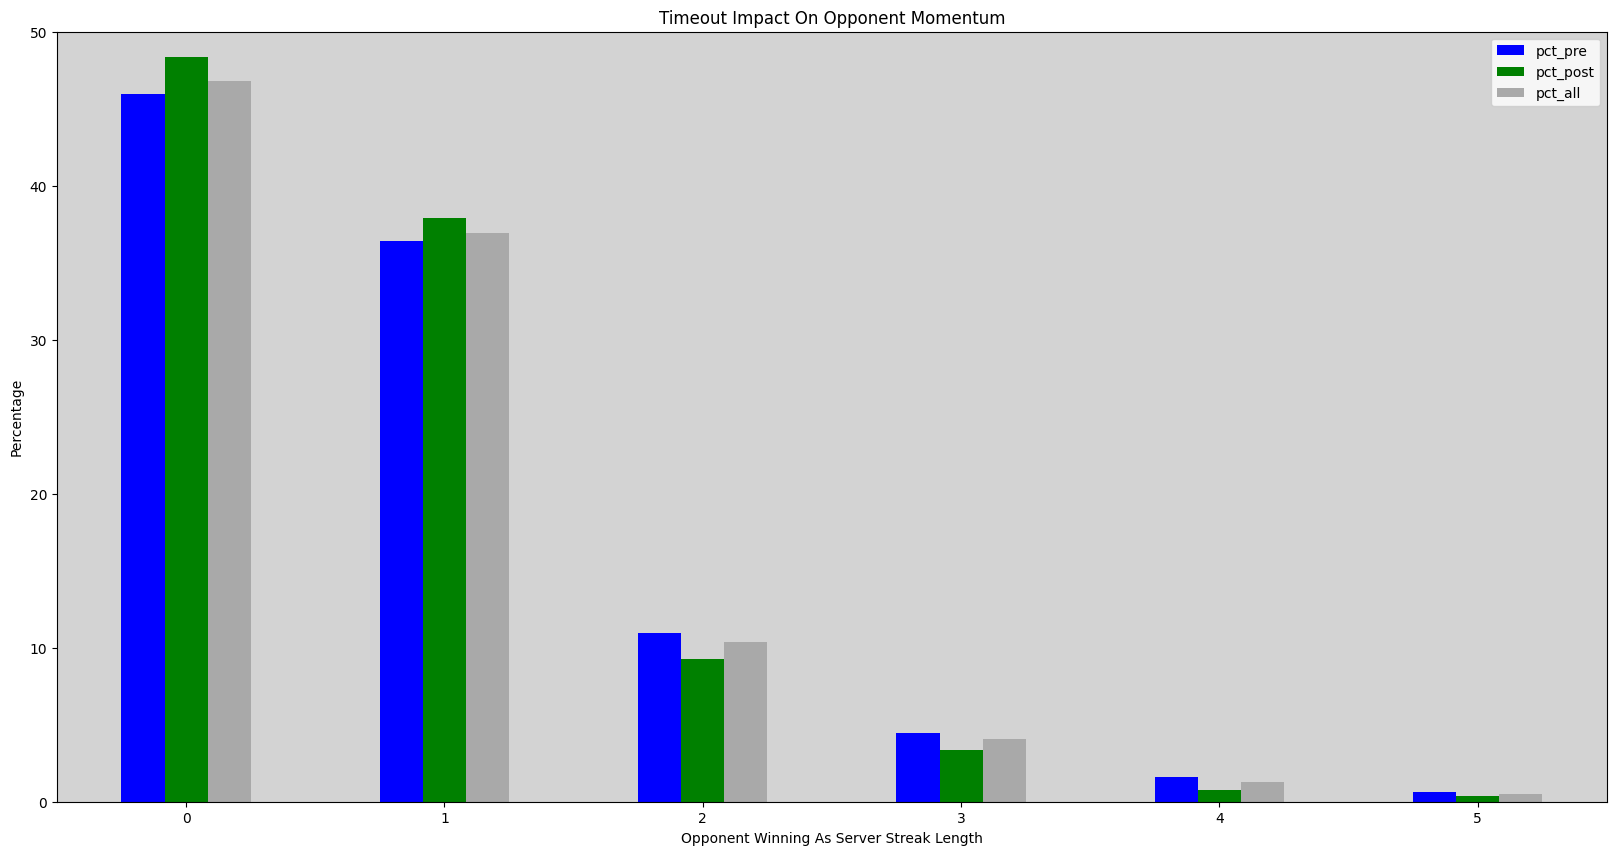

In [63]:
ax = df_pcts_prepost.plot(x="streak",y=["pct_pre","pct_post","pct_all"],figsize=(20, 10), \
                     kind="bar",color={"pct_pre": "blue", "pct_post": "green","pct_all":"darkgrey"}, \
                                       ylim=(0,50),rot=0,title="Timeout Impact On Opponent Momentum", \
                                       xlabel="Opponent Winning As Server Streak Length",ylabel="Percentage")
ax.set_facecolor('lightgrey')

In [65]:
print('flipping coin infinity times would yield .5^(x+1):')
l=[100]
for x in range(6):l.append(l[-1]/2)
df_coin = pd.DataFrame(l[1:],columns=['coin']).round(2)
print(df_coin.astype(str)+"%")
df_pcts_prepost = pd.concat([df_pcts_prepost,df_coin],axis=1)

flipping coin infinity times would yield .5^(x+1):
    coin
0  50.0%
1  25.0%
2  12.5%
3  6.25%
4  3.12%
5  1.56%


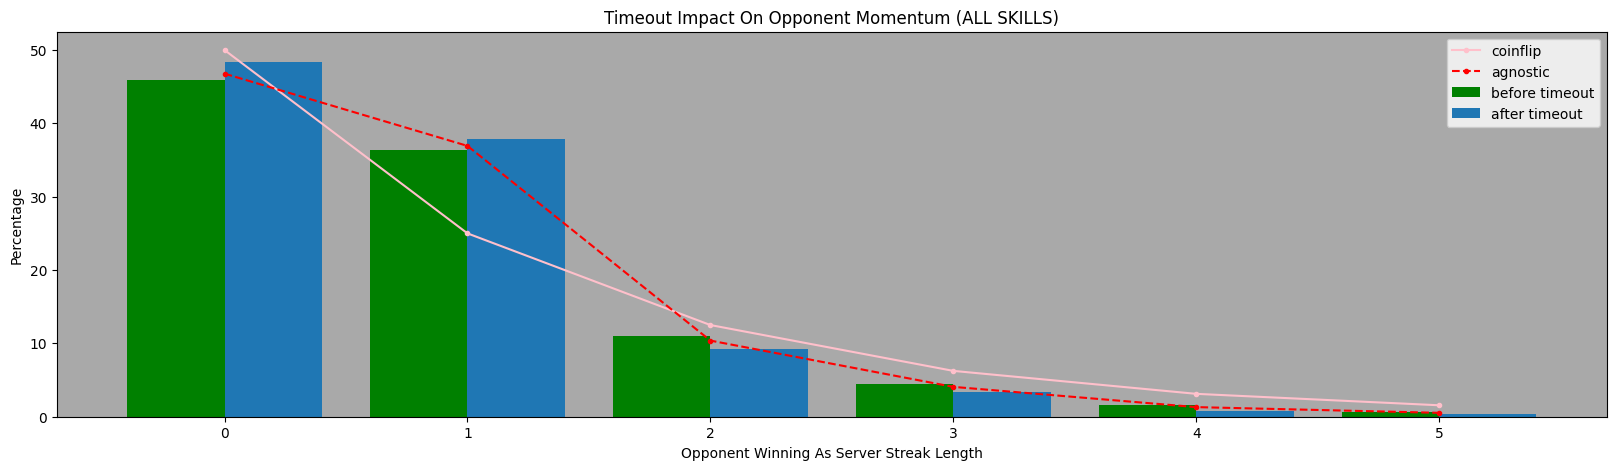

In [72]:
fig, ax = plt.subplots()

streak = df_pcts_prepost.streak
pct_pre = df_pcts_prepost.pct_pre
pct_post = df_pcts_prepost.pct_post
pct_all = df_pcts_prepost.pct_all
pct_coin = df_pcts_prepost.coin
width = 0.4


plt.plot(streak,pct_coin,marker=".",color="pink",label='coinflip')
plt.plot(streak,pct_all,marker=".",color="red",linestyle = "dashed",label='agnostic')

plt.bar(streak-(width/2),pct_pre,width,color="green",label="before timeout")
plt.bar(streak+(width/2),pct_post,width,label="after timeout")

plt.legend(loc="upper right")
ax.set_title("Timeout Impact On Opponent Momentum (ALL SKILLS)")
ax.set_xlabel("Opponent Winning As Server Streak Length")
ax.set_ylabel("Percentage")
ax.set_facecolor('darkgrey')

plt.show()